In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from numpy import linalg
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [115]:
data = pd.read_csv('C:/Users/alexe/Desktop/kaggle/insurance.csv')
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Проверим, есть ли в выборке пропущенные данные

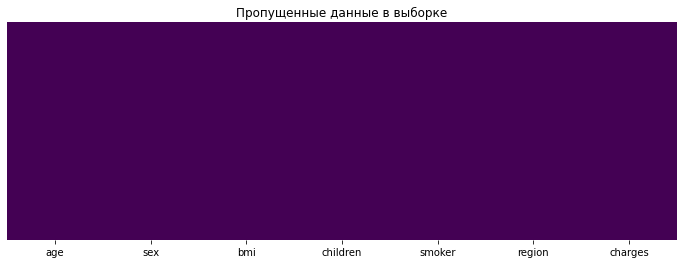

In [117]:
plt.figure(figsize=(12,4))
sns.heatmap(data.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Пропущенные данные в выборке');

В выборке пропущенных данных нет

Посмотрим на корреляцию признаков (нам не нужны зависимые друг от друга признаки).

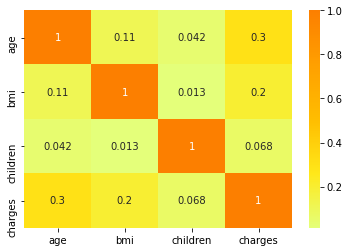

In [118]:
corr = data.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True);

Нет коррелирующих признаков

Построим на распределение целевой переменной

C:\Users\alexe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


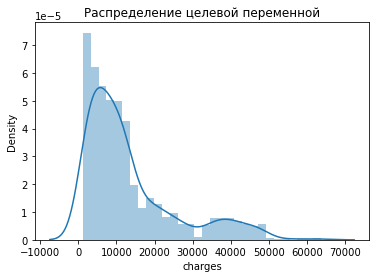

In [121]:
sns.distplot(data['charges'])
plt.title('Распределение целевой переменной')
plt.show()

C:\Users\alexe\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Логарифм распределения страховок')

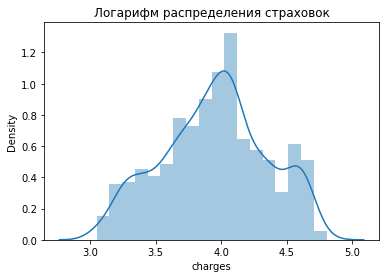

In [73]:
sns.distplot(np.log10(data['charges']))
plt.title('Логарифм распределения страховок')

Как мы видим при применении логарифма к значениям график стремится к графику нормального распределения. Поэтому для дальнейших расчетов будем использовать натуральный логарифм от целевых переменных.

In [74]:
data['charges'] = np.log(data['charges'])
#data

Теперь закодируем категориальные (номинальные) признаки

In [75]:
#One-hot кодирование номинальных признаков с помощью get_dummies
categorical_columns = ['sex','children', 'smoker', 'region']
data_encode = pd.get_dummies(data = data, prefix = 'OHE', prefix_sep='_',
                             columns = categorical_columns,
                             drop_first =True,
                             dtype='int8')
data_encode
#data_encode = data_encode[['age', '0', '1', '2', '3']]

,age,bmi,charges,OHE_male,OHE_1,OHE_2,OHE_3,OHE_4,OHE_5,OHE_yes,OHE_northwest,OHE_southeast,OHE_southwest
0,19,27.900,9.734176,0,0,0,0,0,0,1,0,0,1
1,18,33.770,7.453302,1,1,0,0,0,0,0,0,1,0
2,28,33.000,8.400538,1,0,0,1,0,0,0,0,1,0
3,33,22.705,9.998092,1,0,0,0,0,0,0,1,0,0
4,32,28.880,8.260197,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,9.268661,1,0,0,1,0,0,0,1,0,0
1334,18,31.920,7.698927,0,0,0,0,0,0,0,0,0,0
1335,18,36.850,7.396233,0,0,0,0,0,0,0,0,1,0
1336,21,25.800,7.604867,0,0,0,0,0,0,0,0,0,1


In [76]:
#Перенесем колонку со страховкой в конец таблицы
data_encode = data_encode.drop('charges', 1)
data_encode['charges'] = data['charges']
#data_encode

In [77]:
# categorical_columns = ['sex','children', 'smoker', 'region']
# ct = ColumnTransformer(
#     [('one_hot_encoder', OneHotEncoder(categories='auto'), [1, 4, 5])],   # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
#     remainder='passthrough'                                         # Leave the rest of the columns untouched
# )

# data_encode = ct.fit_transform(data)

In [78]:
X = data_encode.iloc[:,:-1]
y = data_encode.iloc[:, -1:]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
data_train = pd.concat([X_train, y_train], sort=False, axis=1)
data_train

,age,bmi,OHE_male,OHE_1,OHE_2,OHE_3,OHE_4,OHE_5,OHE_yes,OHE_northwest,OHE_southeast,OHE_southwest,charges
1046,43,25.080,0,0,0,0,0,0,0,0,0,0,8.899055
682,39,35.300,1,0,1,0,0,0,1,0,0,1,10.599229
1037,45,30.495,0,1,0,0,0,0,1,1,0,0,10.589749
490,19,32.900,0,0,0,0,0,0,0,0,0,1,7.466670
39,60,39.900,1,0,0,0,0,0,1,0,0,1,10.782561
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,18,31.350,0,0,0,0,1,0,0,0,0,0,8.425339
1130,39,23.870,0,0,0,0,0,1,0,0,1,0,9.057457
1294,58,25.175,1,0,0,0,0,0,0,0,0,0,9.386906
860,37,47.600,0,0,1,0,0,0,1,0,0,1,10.738861


<function matplotlib.pyplot.show(close=None, block=None)>

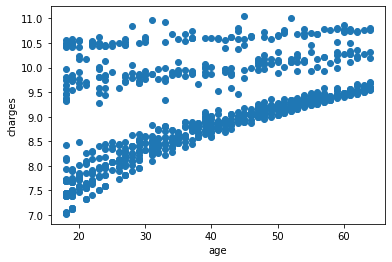

In [122]:
plt.scatter(data_train['age'], data_train['charges'])
plt.xlabel('age')
plt.ylabel('charges')
plt.show

In [81]:
data_train.describe()

,age,bmi,OHE_male,OHE_1,OHE_2,OHE_3,OHE_4,OHE_5,OHE_yes,OHE_northwest,OHE_southeast,OHE_southwest,charges
count,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000,896.000000
mean,39.234375,30.542617,0.512277,0.242188,0.178571,0.119420,0.020089,0.012277,0.209821,0.252232,0.255580,0.235491,9.109155
std,14.212151,5.984036,0.500128,0.428646,0.383207,0.324463,0.140384,0.110180,0.407408,0.434536,0.436431,0.424542,0.921437
min,18.000000,15.960000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.022756
25%,27.000000,26.272500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.480492
50%,39.000000,30.230000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.164955
75%,52.000000,34.488750,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,9.746419
max,64.000000,53.130000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.044407


# Создание модели

Построим модель, используя аналитическую формулу $w = (X^{T}X)^{-1}X^{T}y$. Добавим единичный признак, чтобы избавиться от сдвига $w_{0}$

In [82]:
#добавление единичного признака
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]
print("С добавленным единичным признаком: \n", X_train_0)
print("Без единичного признака:\n", np.c_[X_train])

С добавленным единичным признаком: 
 [[ 1.    43.    25.08  ...  0.     0.     0.   ]
 [ 1.    39.    35.3   ...  0.     0.     1.   ]
 [ 1.    45.    30.495 ...  1.     0.     0.   ]
 ...
 [ 1.    58.    25.175 ...  0.     0.     0.   ]
 [ 1.    37.    47.6   ...  0.     0.     1.   ]
 [ 1.    55.    29.9   ...  0.     0.     1.   ]]
Без единичного признака:
 [[43.    25.08   0.    ...  0.     0.     0.   ]
 [39.    35.3    1.    ...  0.     0.     1.   ]
 [45.    30.495  0.    ...  1.     0.     0.   ]
 ...
 [58.    25.175  1.    ...  0.     0.     0.   ]
 [37.    47.6    0.    ...  0.     0.     1.   ]
 [55.    29.9    1.    ...  0.     0.     1.   ]]


In [83]:
#построение модели
w = linalg.inv(X_train_0.transpose()@X_train_0)@X_train_0.transpose()@y_train
w = [elem for elem in w['charges']]
w

[7.019650259383392,
 0.03444860824034642,
 0.013660454294663362,
 -0.08108977526163419,
 0.14698565499089167,
 0.24248557791029224,
 0.19909879037564138,
 0.4833866339656111,
 0.4077892887459978,
 1.5615082670249423,
 -0.0583716572294225,
 -0.15878192356523846,
 -0.11667702550802597]

In [84]:
#theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train)) 
#theta

In [85]:
parameter = ['w_'+ str(i) for i in range(X_train_0.shape[1])] #лист названий весов (w_0, ...)
columns = ['intersect:x_0=1'] + list(X.columns.values) #названия признаков + единичный
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'w':w}) #новый df, в котором собраны веса для признаков

Теперь построим модель, используя библиотеку sklearn

In [86]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [87]:
w_sklearn = list(lin_reg.intercept_) + list(lin_reg.coef_[0])
w_sklearn

[7.019650259383631,
 0.034448608240346124,
 0.013660454294655898,
 -0.08108977526163483,
 0.14698565499089766,
 0.24248557791029707,
 0.19909879037564565,
 0.4833866339656174,
 0.407789288745984,
 1.5615082670249378,
 -0.05837165722942966,
 -0.1587819235652066,
 -0.11667702550800987]

In [88]:
parameter_df = parameter_df.join(pd.Series(w_sklearn, name='w_sklearn'))
parameter_df

,Parameter,Columns,w,w_sklearn
0,w_0,intersect:x_0=1,7.019650,7.019650
1,w_1,age,0.034449,0.034449
2,w_2,bmi,0.013660,0.013660
3,w_3,OHE_male,-0.081090,-0.081090
4,w_4,OHE_1,0.146986,0.146986
5,w_5,OHE_2,0.242486,0.242486
6,w_6,OHE_3,0.199099,0.199099
7,w_7,OHE_4,0.483387,0.483387
8,w_8,OHE_5,0.407789,0.407789
9,w_9,OHE_yes,1.561508,1.561508


Как видно из таблицы, веса полученные аналитическим путем и с помощью библиотеки sklearn совпадают

Теперь получим предсказания. Для этого скалярно умножим вектор весов на вектор признаков

In [113]:
y_pred = np.dot(X_test_0, w)
d = {'y_true':y_test, 'y_predict':y_pred}
df_true_predict = pd.DataFrame(data=d)
df_true_predict.head(10)

,y_true,y_predict
0,9.115488,9.156225
1,8.570198,8.611515
2,10.286400,11.094759
3,9.137973,9.015612
4,10.426744,9.532262
5,8.419858,8.726155
6,7.657915,7.923367
7,9.561739,9.602699
8,8.224867,8.220401
9,9.236441,9.159188


Теперь посчитаем MSE, RMSE и коэффициент детерминации $R^{2}$

In [97]:
y_test = y_test['charges'].to_list()
MSE = np.sum((y_pred - y_test)**2) / X_test_0.shape[0]
print("MSE = ", MSE)

MSE =  0.18613284341610753


In [95]:
#теперь посчитаем MSE с помощью sklearn
MSE_sk = mean_squared_error(y_test, y_pred)
print("MSE_sk = ", MSE_sk)

MSE_sk =  0.18613284341610753


Полученное MSE - это много или мало? На этот вопрос ответит $R^2$

In [104]:
y_mean = np.sum(y_test) / len(y_test)
r2 = 1 - (np.sum((y_pred - y_test)**2) / (np.sum((y_test - y_mean)**2)))
print("R2 = ", r2)

R2 =  0.7778142994593281


In [105]:
#с помощью sklearn
r2_sk = r2_score(y_test, y_pred)
print("R2_sk = ", r2_sk)

R2_sk =  0.7778142994593281


Получили хороший R2 => модель выдает хорошие предсказания

# Градиентный спуск